Problemas de classificação multiclasse
============================

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import ConcatDataset, DataLoader

In [3]:
# Transformação: converte a imagem em tensor e normaliza para o intervalo [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalização para [-1, 1]
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=938, shuffle=True)  # Tamanho de batch de treino
test_dataloader = DataLoader(test_dataset, batch_size=157, shuffle=False)   # Tamanho de batch de teste

100%|██████████| 26421880/26421880 [00:01<00:00, 15717235.85it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 268830.03it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4947509.74it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9873011.88it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
print(f"Número total de batches no DataLoader de treino: {len(train_dataloader)}")
print(f"Número total de batches no DataLoader de teste: {len(test_dataloader)}")
print(f"Número total de amostras no dataset de treino: {len(train_dataset)}")
print(f"Número total de amostras no dataset de teste: {len(test_dataset)}")


Número total de batches no DataLoader de treino: 64
Número total de batches no DataLoader de teste: 64
Número total de amostras no dataset de treino: 60000
Número total de amostras no dataset de teste: 10000


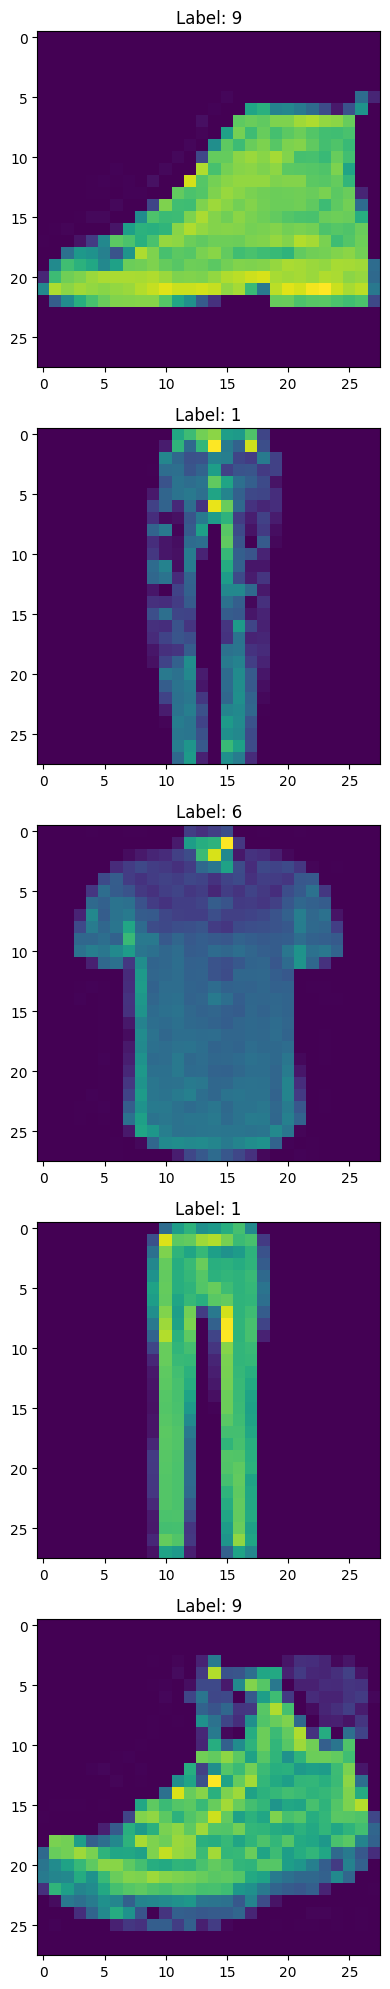

In [5]:
# Função para mostrar as 5 primeiras imagens na vertical com resolução 28x28
def show_first_images_vertical(dataloader, n=5):
    # Pegar o primeiro batch de imagens
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    # Mostrar as primeiras 'n' imagens na vertical
    plt.figure(figsize=(4, 4*n))  # Ajustar o tamanho da figura para manter a proporção 28x28
    for i in range(n):
        plt.subplot(n, 1, i+1)
        img = images[i].squeeze(0).numpy()  # Remover a dimensão do canal e converter para numpy
        plt.imshow(img, aspect='auto')  # Garantir que a resolução seja mantida
        plt.title(f'Label: {labels[i].item()}')


    plt.tight_layout()  # Ajustar o layout para que as imagens não se sobreponham
    plt.show()

# Mostrar as primeiras 5 imagens na vertical com resolução 28x28
show_first_images_vertical(train_dataloader, n=5)


In [6]:
class RedeNeural(nn.Module):
    def __init__(self, input_size=28*28, num_classes=10):
        super(RedeNeural, self).__init__()
        # Camada totalmente conectada: entrada de 784 (28x28) e saída de 128 neurônios
        self.fc1 = nn.Linear(input_size, 128)
        # Camada oculta com 128 neurônios e saída de 64 neurônios
        self.fc2 = nn.Linear(128, 64)
        # Camada de saída com 10 neurônios (para 10 classes)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten a imagem 28x28 para um vetor de 784
        x = F.relu(self.fc1(x))  # Primeira camada com ReLU
        x = F.relu(self.fc2(x))  # Segunda camada com ReLU
        x = self.fc3(x)  # Camada de saída (sem softmax, pois a CrossEntropyLoss já aplica)
        return x


In [7]:
# Definir o dispositivo (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instanciar o modelo e movê-lo para o dispositivo
model = RedeNeural().to(device)

# Definir a função de perda e o otimizador
criterion = nn.CrossEntropyLoss()  # A CrossEntropyLoss aplica softmax internamente
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
# Função de treinamento
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()  # Colocar o modelo em modo de treinamento

    for epoch in range(epochs):
        running_loss = 0.0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)  # Mover os dados para a GPU (se disponível)

            optimizer.zero_grad()  # Zerar os gradientes

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Calcular a perda

            # Backpropagation e otimização
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Média da perda por época
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Chamar a função de treinamento
epochs = 10
train_model(model, train_dataloader, criterion, optimizer, epochs)


Epoch [1/10], Loss: 0.8918
Epoch [2/10], Loss: 0.4950
Epoch [3/10], Loss: 0.4388
Epoch [4/10], Loss: 0.4066
Epoch [5/10], Loss: 0.3812
Epoch [6/10], Loss: 0.3647
Epoch [7/10], Loss: 0.3509
Epoch [8/10], Loss: 0.3383
Epoch [9/10], Loss: 0.3272
Epoch [10/10], Loss: 0.3150


In [9]:
print(f"Número total de amostras no dataset de treino: {len(train_dataset)}")
print(f"Número total de amostras no dataset de teste: {len(test_dataset)}")

Número total de amostras no dataset de treino: 60000
Número total de amostras no dataset de teste: 10000


In [10]:
# Função para avaliar o modelo
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Colocar o modelo em modo de avaliação
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Desabilitar o cálculo dos gradientes
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Prever a classe com maior probabilidade
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Média da perda e acurácia no teste
    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Avaliar o modelo no dataset de teste
evaluate_model(model, test_dataloader, criterion)


Test Loss: 0.3719, Accuracy: 86.27%


In [11]:
def mixup_data(x, y, alpha=1.0):
    '''Aplica MixUp aos dados e rótulos'''
    if alpha > 0:
        lam = torch.distributions.Beta(alpha, alpha).sample().item()
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    '''Função de perda ajustada para MixUp'''
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# No loop de treinamento:
for images, labels in train_dataloader:
    images, labels = images.to(device), labels.to(device)

    # Aplicar MixUp
    images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=1.0)

    # Forward pass
    outputs = model(images)

    # Calcular a loss com MixUp
    loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

    # Backward pass e otimização
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

def train_model_mixup(model, train_loader, criterion, optimizer, scheduler, epochs=10, alpha=0.2):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            if epoch < 5:
                inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha)
                outputs = model(inputs)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

train_model_mixup(model, train_dataloader, criterion, optimizer, scheduler, epochs=10, alpha=0.2)


Epoch [1/10], Loss: 0.6754
Epoch [2/10], Loss: 0.6801
Epoch [3/10], Loss: 0.6315
Epoch [4/10], Loss: 0.6052
Epoch [5/10], Loss: 0.5595
Epoch [6/10], Loss: 0.3107
Epoch [7/10], Loss: 0.3006
Epoch [8/10], Loss: 0.2965
Epoch [9/10], Loss: 0.2939
Epoch [10/10], Loss: 0.2917


In [13]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%')

evaluate_model(model, test_dataloader, criterion)


Test Loss: 0.3583, Accuracy: 87.28%


Test Loss: 0.3583, Accuracy: 87.28%


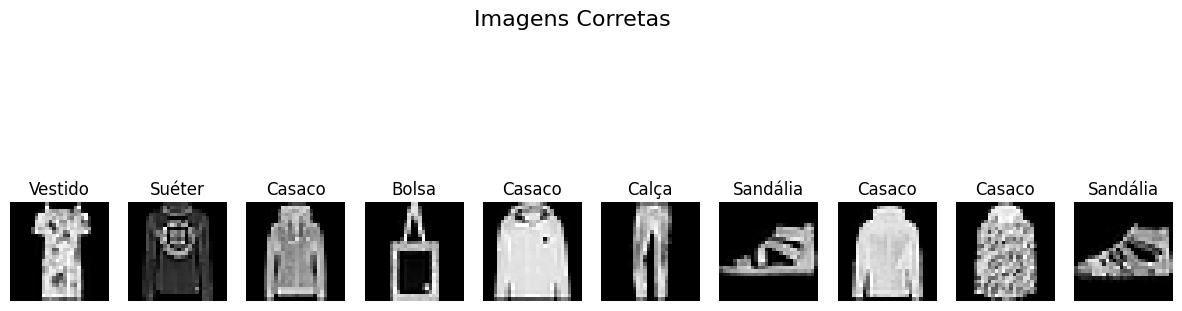

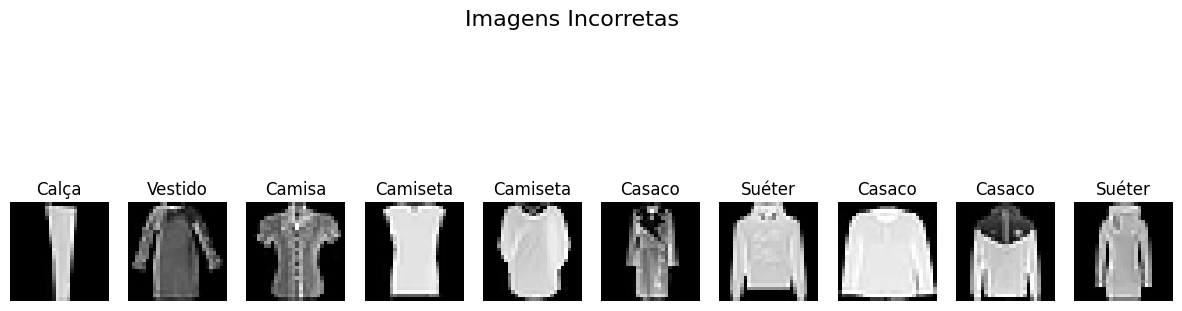

In [14]:
import matplotlib.pyplot as plt
import random

# Defina os nomes das classes para o dataset FashionMNIST
class_names = [
    'Camiseta',  # T-shirt/top
    'Calça',     # Trouser
    'Suéter',    # Pullover
    'Vestido',   # Dress
    'Casaco',    # Coat
    'Sandália',  # Sandal
    'Camisa',    # Shirt
    'Tênis',     # Sneaker
    'Bolsa',     # Bag
    'Bota ankle' # Ankle boot
]

def evaluate_model(model, test_loader, criterion, class_names):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    correct_images = []
    correct_labels = []
    incorrect_images = []
    incorrect_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Armazenar imagens corretas e incorretas
            for i in range(labels.size(0)):
                if predicted[i] == labels[i]:
                    correct_images.append(inputs[i].cpu())
                    correct_labels.append(labels[i].cpu())
                else:
                    incorrect_images.append(inputs[i].cpu())
                    incorrect_labels.append(labels[i].cpu())

    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Selecionar um número aleatório de imagens corretas e incorretas
    display_correct_images(correct_images, correct_labels, class_names, num_images=10)
    display_incorrect_images(incorrect_images, incorrect_labels, class_names, num_images=10)

def display_correct_images(images, labels, class_names, num_images=5):
    plt.figure(figsize=(15, 5))
    plt.suptitle("Imagens Corretas", fontsize=16)
    
    # Selecionar amostra aleatória das imagens corretas
    random_samples = random.sample(list(zip(images, labels)), min(num_images, len(images)))
    
    for i, (image, label) in enumerate(random_samples):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(class_names[label.item()])
    plt.show()

def display_incorrect_images(images, labels, class_names, num_images=5):
    plt.figure(figsize=(15, 5))
    plt.suptitle("Imagens Incorretas", fontsize=16)
    
    # Selecionar amostra aleatória das imagens incorretas
    random_samples = random.sample(list(zip(images, labels)), min(num_images, len(images)))
    
    for i, (image, label) in enumerate(random_samples):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(class_names[label.item()])
    plt.show()

# Chame a função para avaliar o modelo
evaluate_model(model, test_dataloader, criterion, class_names)


Train
============================

Sem augmentation

Epoch [10/10], Loss: 0.3150

Com augmentation

Epoch [10/10], Loss: 0.2917


---

Test
============================

**Sem augmentation**

Test Loss: 0.3719, Accuracy: 86.27%

**Com augmentation**

Test Loss: 0.3583, Accuracy: 87.28%

# Classes do Dataset FashionMNIST

O dataset **FashionMNIST** contém imagens de roupas e acessórios, organizadas em 10 classes:

| Rótulo | Classe em Inglês | Classe em Português |
|--------|------------------|---------------------|
| 0      | T-shirt/top      | Camiseta            |
| 1      | Trouser          | Calça               |
| 2      | Pullover         | Suéter              |
| 3      | Dress            | Vestido             |
| 4      | Coat             | Casaco              |
| 5      | Sandal           | Sandália            |
| 6      | Shirt            | Camisa              |
| 7      | Sneaker          | Tênis               |
| 8      | Bag              | Bolsa               |
| 9      | Ankle boot       | Bota ankle          |


In [15]:
# Configurações Gerais
batch_size = 128
epochs = 10
lr = 0.001

In [16]:
# Transformação do Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalização para [-1, 1]
])


In [17]:
# Carregar o Dataset FashionMNIST (roupas)
fashion_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Carregar o Dataset MNIST (números)
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Modificar os rótulos do MNIST para que comecem a partir de 10
mnist_labels = mnist_dataset.targets + 10  # Roupas: 0-9, Números: 10-19
mnist_dataset.targets = mnist_labels

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 39255736.47it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 1011470.20it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 9318511.06it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 3606688.52it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [18]:
from torch.utils.data import ConcatDataset, DataLoader

# Combinar os dois datasets
combined_dataset = ConcatDataset([fashion_dataset, mnist_dataset])
# Criar o DataLoader
combined_dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)


In [19]:
# Definir a arquitetura da Rede Neural
class SimpleNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
# Inicializar o modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN(num_classes=20).to(device)  # 10 classes para roupas e 10 para números
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Função de Treinamento
def train_model(model, dataloader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}')


In [21]:
# Treinar o modelo
print("Treinando o modelo com FashionMNIST e MNIST...")
train_model(model, combined_dataloader, criterion, optimizer, epochs)

# Dicionário de classes
class_names = [
    "Camiseta", "Calça", "Suéter", "Vestido", "Casaco", 
    "Sandália", "Camisa", "Tênis", "Bolsa", "Bota ankle", 
    "Dígito 0", "Dígito 1", "Dígito 2", "Dígito 3", "Dígito 4", 
    "Dígito 5", "Dígito 6", "Dígito 7", "Dígito 8", "Dígito 9"
]

Treinando o modelo com FashionMNIST e MNIST...
Epoch [1/10], Loss: 0.4869
Epoch [2/10], Loss: 0.3047
Epoch [3/10], Loss: 0.2560
Epoch [4/10], Loss: 0.2309
Epoch [5/10], Loss: 0.2119
Epoch [6/10], Loss: 0.1973
Epoch [7/10], Loss: 0.1871
Epoch [8/10], Loss: 0.1774
Epoch [9/10], Loss: 0.1697
Epoch [10/10], Loss: 0.1625


In [22]:
# Função para exibir e classificar as imagens
def display_and_classify(model, dataloader):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Armazenar imagens corretas e incorretas
    correct_images = []
    correct_labels = []
    incorrect_images = []
    incorrect_labels = []

    for i in range(len(images)):
        if predicted[i] == labels[i]:
            correct_images.append(images[i].cpu())
            correct_labels.append(labels[i].cpu())
        else:
            incorrect_images.append(images[i].cpu())
            incorrect_labels.append(labels[i].cpu())

    # Exibir as imagens corretas
    plt.figure(figsize=(20, 8))  # Aumentar o tamanho da figura
    plt.suptitle("Imagens Corretas", fontsize=16)
    for i in range(min(10, len(correct_images))):  # Exibir até 10 imagens corretas
        plt.subplot(2, 5, i + 1)  # 2 linhas, 5 colunas
        plt.imshow(correct_images[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Predição: {class_names[correct_labels[i].item()]}')  # Exibir predição
    plt.show()

    # Exibir as imagens incorretas
    plt.figure(figsize=(20, 8))  # Aumentar o tamanho da figura
    plt.suptitle("Imagens Incorretas", fontsize=16)
    for i in range(min(10, len(incorrect_images))):  # Exibir até 10 imagens incorretas
        plt.subplot(2, 5, i + 1)  # 2 linhas, 5 colunas
        plt.imshow(incorrect_images[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Predição: {class_names[predicted[i].item()]}')  # Exibir predição e rótulo real
    plt.show()

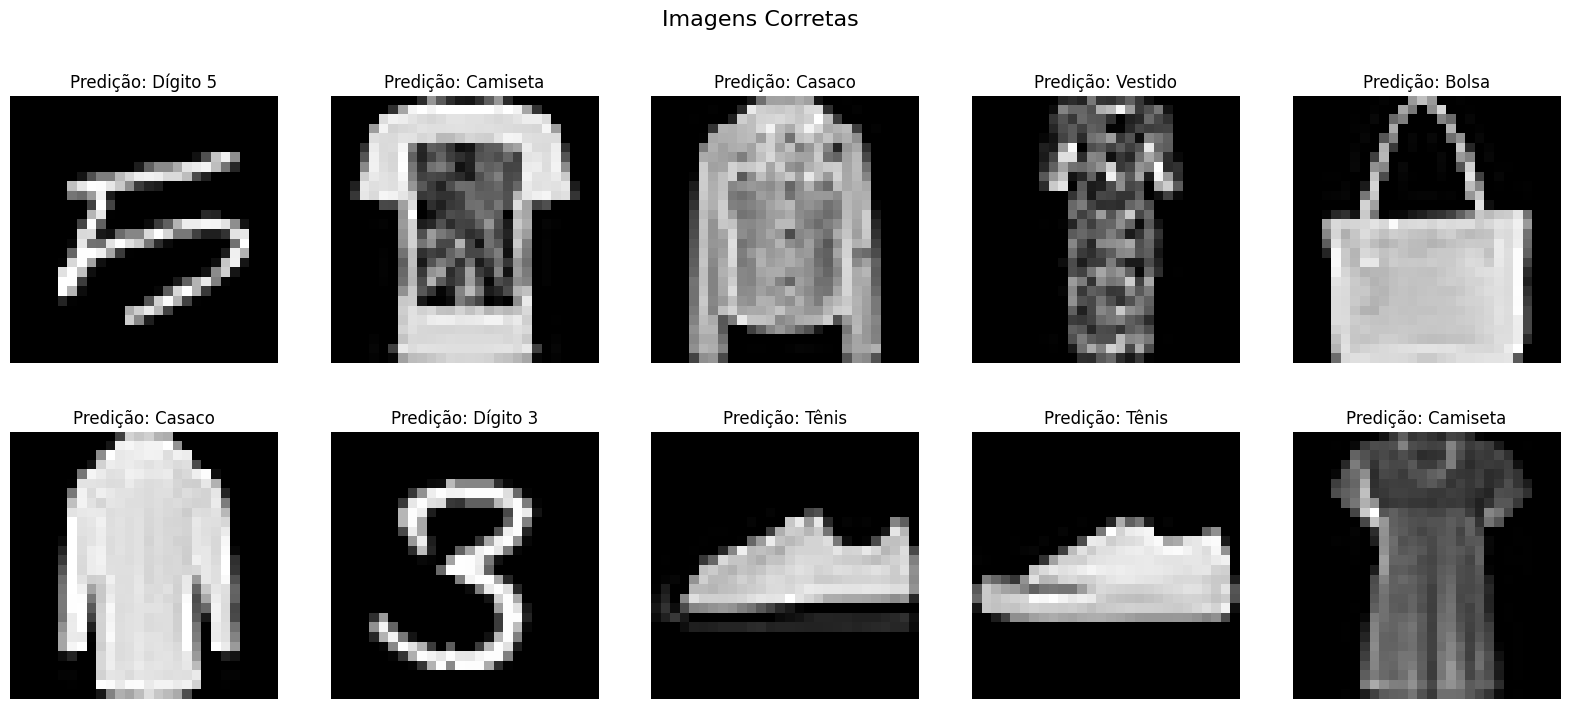

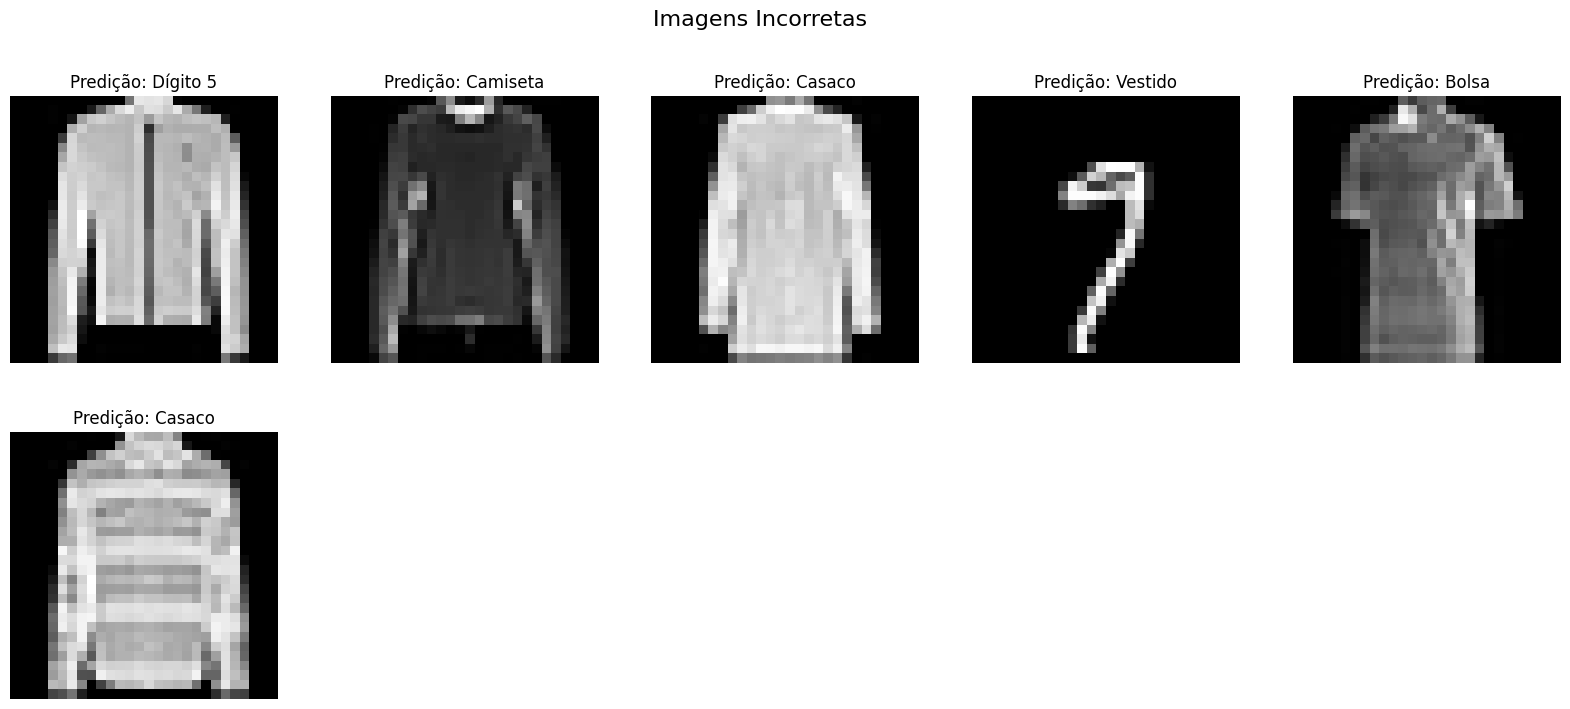

In [23]:
# Exibir imagens e predições
display_and_classify(model, combined_dataloader)


# Classes dos Datasets

## FashionMNIST (Roupas)

O dataset **FashionMNIST** contém imagens de roupas e acessórios, organizadas em 10 classes:

| Rótulo | Classe               |
|--------|----------------------|
| 0      | Camiseta             |
| 1      | Calça                |
| 2      | Suéter               |
| 3      | Vestido              |
| 4      | Casaco               |
| 5      | Sandália             |
| 6      | Camisa               |
| 7      | Tênis                |
| 8      | Bolsa                |
| 9      | Bota ankle           |

---

## MNIST (Números)

O dataset **MNIST** contém imagens de dígitos de 0 a 9, organizadas em 10 classes:

| Rótulo | Classe       |
|--------|--------------|
| 10      | Dígito 0    |
| 11      | Dígito 1    |
| 12      | Dígito 2    |
| 13      | Dígito 3    |
| 14      | Dígito 4    |
| 15      | Dígito 5    |
| 16      | Dígito 6    |
| 17      | Dígito 7    |
| 18      | Dígito 8    |
| 19      | Dígito 9    |

---

## Combinação dos Datasets

Ao combinar os datasets:

- **FashionMNIST** utiliza rótulos de **0 a 9** para roupas.
- **MNIST** utiliza rótulos de **10 a 19** para dígitos, evitando conflitos.

Assim, o modelo pode classificar tanto imagens de roupas quanto imagens de números.


In [24]:
# Configurações Gerais
image_size = 28
batch_size = 128
latent_dim = 100
epochs = 10
lr = 0.0002
beta1 = 0.5

In [25]:
# Transformação do Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalização para [-1, 1]
])

In [26]:
# Carregar o Dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [27]:
# Definir o Gerador
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [28]:
# Definir o Discriminador
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1).squeeze(1)

In [29]:
# Inicializar Modelos e Otimizadores
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [30]:
# Função para Mostrar Apenas Imagens Geradas
def show_generated_images(fake_images, num_images=10):
    plt.figure(figsize=(15, 5))  # Tamanho da figura
    for i in range(num_images):
        img_fake = (fake_images[i].cpu().detach().numpy().squeeze() + 1) / 2  # Reescala de [-1, 1] para [0, 1]
        plt.subplot(2, 5, i + 1)  # 2 linhas, 5 colunas
        plt.imshow(img_fake, cmap='gray')
        plt.axis('off')

    plt.show()

Epoch [1/10]  Loss D: 0.31181564927101135  Loss G: 1.5056097507476807


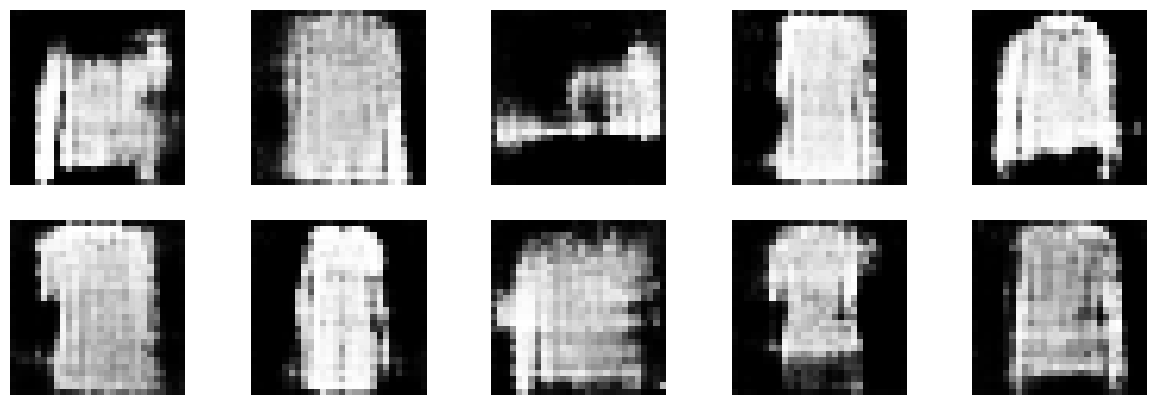

Epoch [2/10]  Loss D: 0.3465312421321869  Loss G: 1.3966426849365234


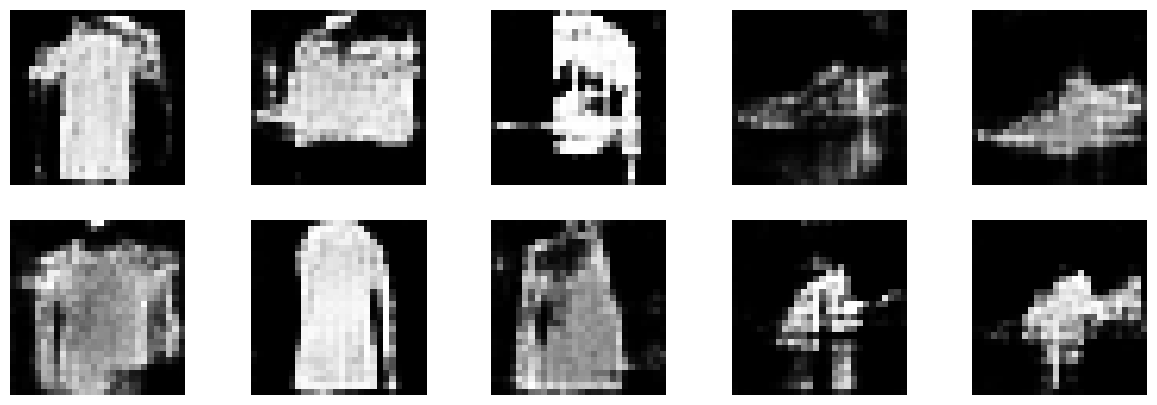

Epoch [3/10]  Loss D: 0.4815463423728943  Loss G: 1.7876527309417725


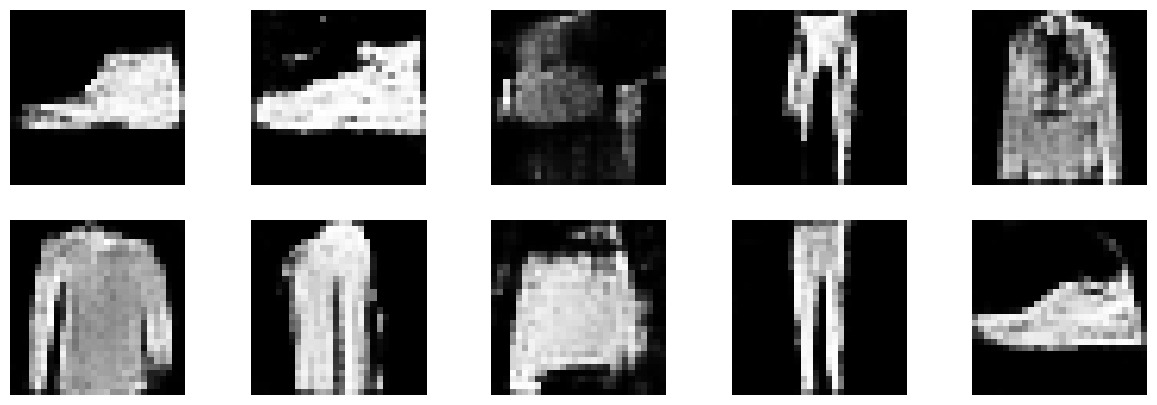

Epoch [4/10]  Loss D: 0.37179064750671387  Loss G: 1.593093752861023


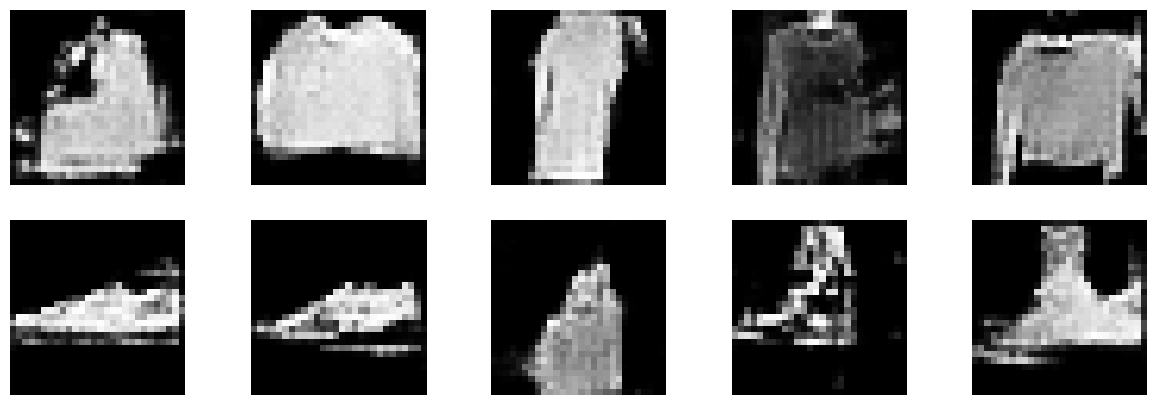

Epoch [5/10]  Loss D: 0.4629251956939697  Loss G: 1.1986451148986816


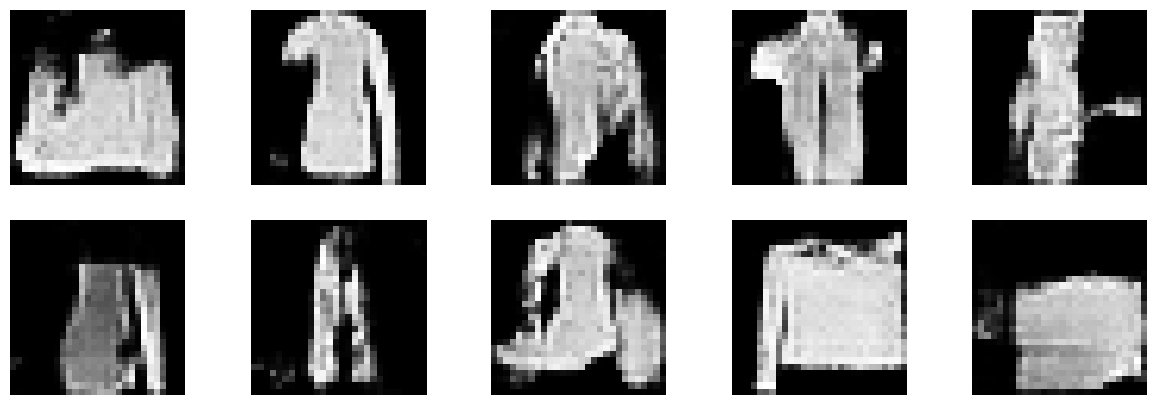

Epoch [6/10]  Loss D: 0.4907233715057373  Loss G: 0.8147664070129395


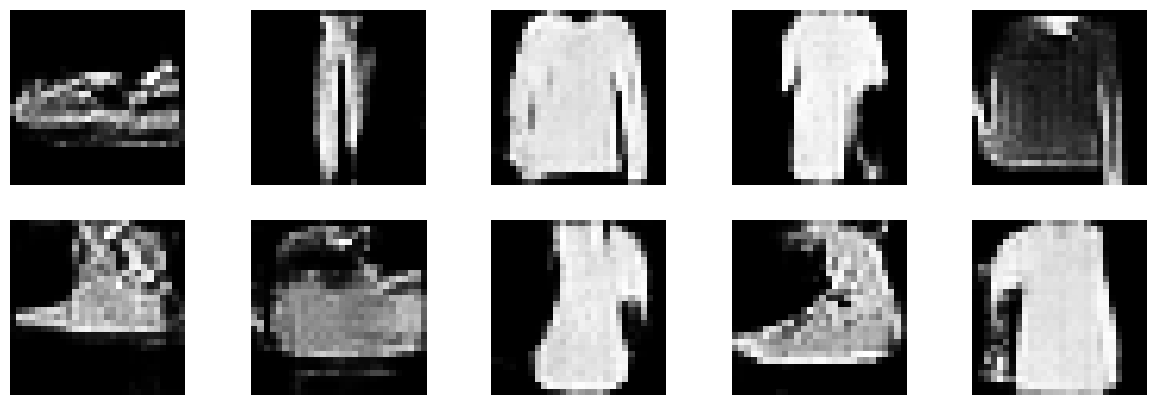

Epoch [7/10]  Loss D: 0.451310932636261  Loss G: 1.099980115890503


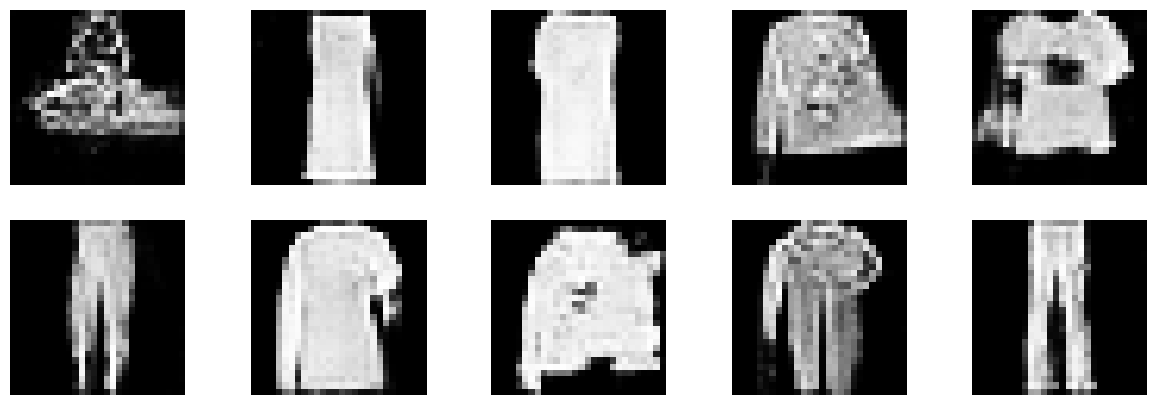

Epoch [8/10]  Loss D: 0.4761615991592407  Loss G: 1.4993499517440796


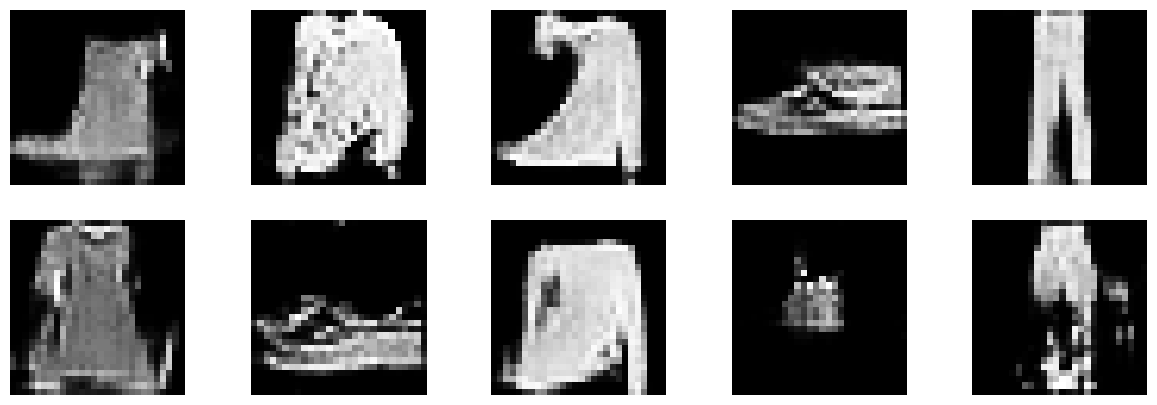

Epoch [9/10]  Loss D: 0.4440400004386902  Loss G: 1.0335527658462524


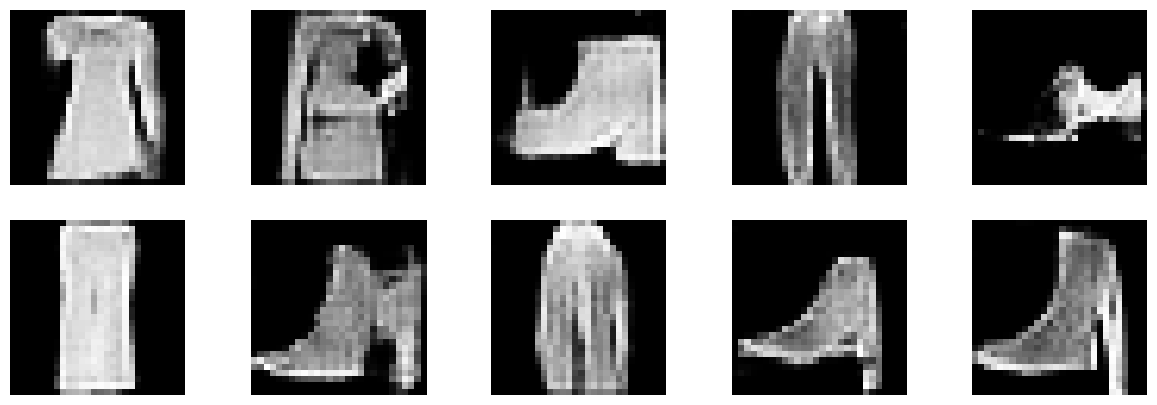

Epoch [10/10]  Loss D: 0.47095948457717896  Loss G: 1.7244696617126465


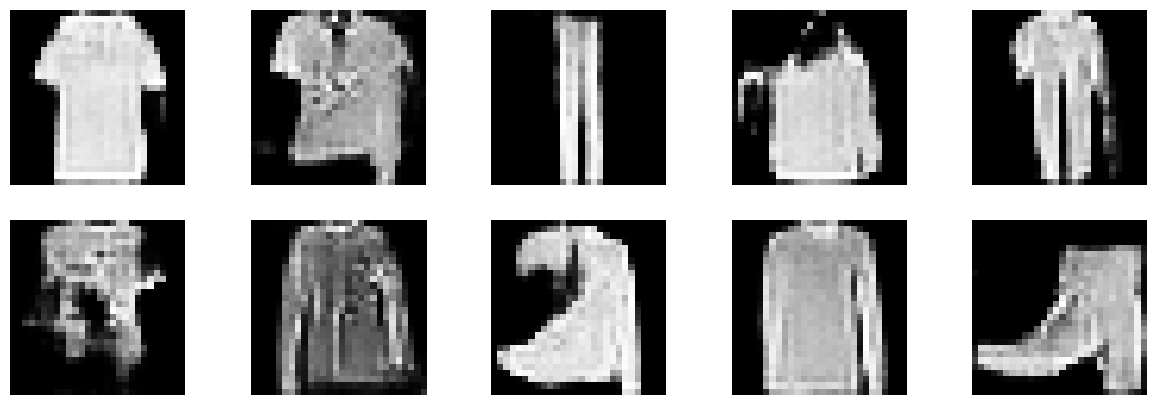

In [31]:
# Treinamento do DCGAN
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_dataloader):
        real_imgs = imgs.to(device)
        real_labels = torch.ones(imgs.size(0), device=device)
        fake_labels = torch.zeros(imgs.size(0), device=device)

        # Treinar Discriminador
        optimizerD.zero_grad()
        output_real = discriminator(real_imgs)
        loss_real = criterion(output_real, real_labels)

        z = torch.randn(imgs.size(0), latent_dim, 1, 1, device=device)
        fake_imgs = generator(z)
        output_fake = discriminator(fake_imgs.detach())
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizerD.step()

        # Treinar Gerador
        optimizerG.zero_grad()
        output_fake = discriminator(fake_imgs)
        loss_G = criterion(output_fake, real_labels)
        loss_G.backward()
        optimizerG.step()

    print(f"Epoch [{epoch+1}/{epochs}]  Loss D: {loss_D.item()}  Loss G: {loss_G.item()}")

    # Salvar imagens geradas a cada época
    save_image(fake_imgs.data[:25], f"fashionmnist_{epoch+1}.png", nrow=5, normalize=True)

    # Mostrar apenas imagens geradas
    if (epoch + 1) % 1 == 0:  # Exibir a cada época
        show_generated_images(fake_imgs, num_images=10)  # Exibe 10 imagens geradas


Epoch [1/10]  Loss D: 0.5227504372596741  Loss G: 1.4160077571868896


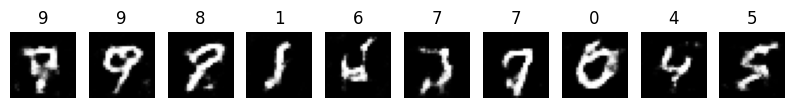

Epoch [2/10]  Loss D: 0.6081473231315613  Loss G: 1.593996524810791


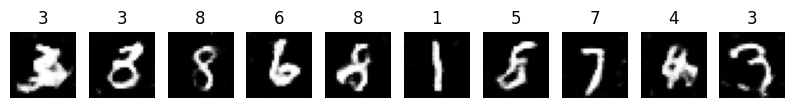

Epoch [3/10]  Loss D: 0.8956649303436279  Loss G: 0.6588579416275024


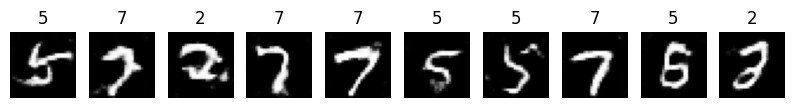

Epoch [4/10]  Loss D: 0.5285050868988037  Loss G: 1.4326624870300293


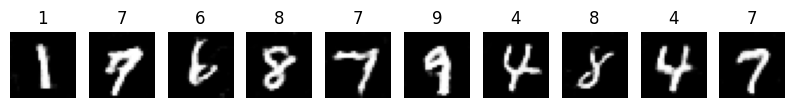

Epoch [5/10]  Loss D: 0.4098404049873352  Loss G: 1.357068419456482


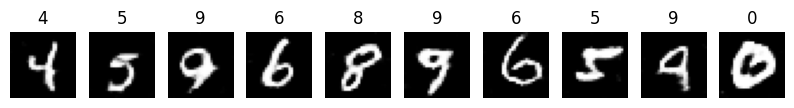

Epoch [6/10]  Loss D: 1.0744171142578125  Loss G: 0.9849004149436951


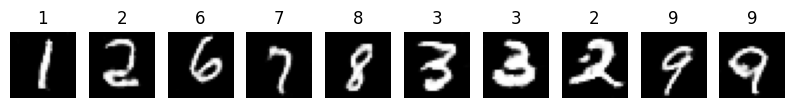

Epoch [7/10]  Loss D: 0.6644529104232788  Loss G: 0.902977705001831


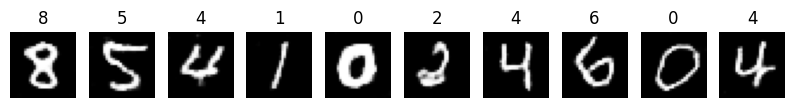

Epoch [8/10]  Loss D: 0.43589961528778076  Loss G: 1.2064428329467773


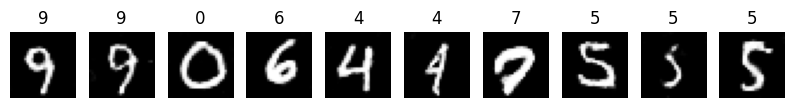

Epoch [9/10]  Loss D: 0.9451438188552856  Loss G: 0.7366079092025757


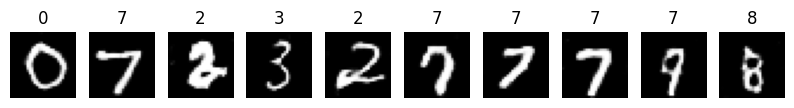

Epoch [10/10]  Loss D: 0.8217464089393616  Loss G: 0.6391348242759705


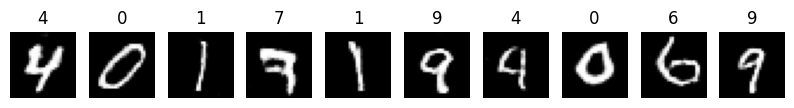

In [32]:
# Configurações para o dataset MNIST (números)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalização para MNIST
])

# Carregar o dataset MNIST
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

# Definir a arquitetura do DCGAN com rótulos condicionais
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes=10):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + num_classes, 128, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x, labels):
        # Concatenar o vetor latente com o embedding dos rótulos
        labels = self.label_embedding(labels).view(labels.size(0), -1, 1, 1)
        x = torch.cat([x, labels], dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, num_classes=10):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, 28*28)  # 28x28 para cada imagem de MNIST
        self.model = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten(),
            nn.Linear(128*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        # Concatenar a imagem com o embedding dos rótulos
        labels = self.label_embedding(labels).view(labels.size(0), 1, 28, 28)
        x = torch.cat([x, labels], dim=1)
        return self.model(x)

# Inicializar o gerador e o discriminador
latent_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Configurar otimização e função de perda
optimizerG = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# Função para exibir imagens geradas com rótulo
def show_generated_images(images, labels, num_images=10):
    images = images[:num_images].detach().cpu()
    labels = labels[:num_images].detach().cpu()
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(labels[i].item())
    plt.show()

# Treinamento do DCGAN condicional
epochs = 10

for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(train_dataloader):
        real_imgs = imgs.to(device)
        labels = labels.to(device)
        real_labels = torch.ones((imgs.size(0), 1), device=device)
        fake_labels = torch.zeros((imgs.size(0), 1), device=device)

        # Treinar o Discriminador
        optimizerD.zero_grad()
        output_real = discriminator(real_imgs, labels)
        loss_real = criterion(output_real, real_labels)

        z = torch.randn(imgs.size(0), latent_dim, 1, 1, device=device)
        random_labels = torch.randint(0, 10, (imgs.size(0),), device=device)  # Rótulos aleatórios para os números
        fake_imgs = generator(z, random_labels)
        output_fake = discriminator(fake_imgs.detach(), random_labels)
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizerD.step()

        # Treinar o Gerador
        optimizerG.zero_grad()
        output_fake = discriminator(fake_imgs, random_labels)
        loss_G = criterion(output_fake, real_labels)
        loss_G.backward()
        optimizerG.step()

    print(f"Epoch [{epoch+1}/{epochs}]  Loss D: {loss_D.item()}  Loss G: {loss_G.item()}")

    # Salvar e exibir imagens geradas a cada época
    save_image(fake_imgs.data[:25], f"mnist_conditional_generated_{epoch+1}.png", nrow=5, normalize=True)

    # Mostrar algumas imagens geradas com os rótulos
    if (epoch + 1) % 1 == 0:
        show_generated_images(fake_imgs, random_labels, num_images=10)
